# Latent Dirichlet Allocation (LDA)

## Preprocess Data

In [2]:
#import packages
import pandas as pd
import ast
import re
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
%matplotlib inline

import math

In [160]:
covid = pd.read_pickle(r'final_processed_with_ADI.pkl')
covid = covid.reset_index()

In [49]:
covid['ADI'].quantile([.2, .8]) 

0.2    16
0.8    62
Name: ADI, dtype: object

In [50]:
#covid['SDI_level'] = covid.apply(lambda x: 'low' if x <=50 ('high' if x>50 else x) for x in covid['SDI'])
covid['ADI_level'] = pd.Series([])
#covid['SDI_level_extreme'] = pd.Series([])
for i in range(len(covid)):
    if covid['ADI'][i] <=16:
        covid['ADI_level'][i] ='low'
    elif covid['ADI'][i] > 16 and covid['ADI'][i] < 62:
        covid['ADI_level'][i] = 'mid'
    elif covid['ADI'][i] >= 62:
        covid['ADI_level'][i] = 'high'

In [73]:
covid.head()

,index,user_id,status_id,created_at,month,date,stemmer,County,State,ADI,Code,IsHotspot,ADI_level
0,0,740588957797220352,1220051216081788929,1579717852,January,23.0,"[lysol, da, fuck, outta, everyth, bc, aint, ca...",Tarrant County,Texas,55,48439,False,mid
1,1,1971510733,1220057558033014784,1579719364,January,23.0,"[coronaviru, confirm, washington]",Allegan County,Michigan,55,26005,False,mid
2,2,2419585452,1220059356697452546,1579719792,January,23.0,"[hmmmmm, could, coronaviru, soon, new, plagu]",Leon County,Florida,56.5,12073,False,mid
3,3,14413869,1220059703104815104,1579719875,January,23.0,"[million, peopl, wuhan, larger, new, york, cit...",Maricopa County,Arizona,48,04013,True,mid
4,4,1601210089,1220061420890607617,1579720285,January,23.0,"[wuhan, cut, inflow, outflow, transport, annou...",Washington,District of Columbia,13,11001,False,low


In [74]:
len(covid)

270196

In [14]:
covid_list = covid['stemmer'].tolist()
# Create Dictionary
id2word = corpora.Dictionary(covid_list)

len(id2word)

159463

In [15]:
original_wordlist = []
for k, v in id2word.items():
    original_wordlist.append(v)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
id2word.filter_extremes(no_below = 20, no_above=0.5, keep_n = 160000)
len(id2word)

new_wordlist = []
for k, v in id2word.items():
    new_wordlist.append(v)

# Create Corpus
texts = covid_list

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

empty = []
for i in range(len(corpus)):
    if len(corpus[i]) == 0:
        empty.append(i)

covid = covid.reset_index(drop =True)
covid_clean = covid.drop(empty).reset_index(drop=True)
len(covid_clean) == len(covid) - len(empty)

for i in range(len(covid_clean)):
    for w in covid_clean['stemmer'][i]:
        if w not in new_wordlist:
            covid_clean['stemmer'][i].remove(w)
empty2 = []
for i in range(len(covid_clean)):
    if len(covid_clean['stemmer'][i]) == 0:
        empty2.append(i)

covid_list = covid_clean['stemmer'].tolist()
# Create Corpus
texts = covid_list

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

len(covid_clean)

269556

In [16]:
len(covid_clean) == len(covid) - len(empty)

True

In [17]:
len(corpus) == len(covid_clean)

True

## Build and Select Model

In [18]:
import os
#set path to Mallet
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet' # update this path

In [53]:
#for choosing number of topics
def evaluate_model(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    #perplexity_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha= 5.0, random_seed = 750)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        #perplexity = model.log_perplexity(corpus)
        #perplexity_values.append(perplexity)
    return model_list, coherence_values#, perplexity_values

In [54]:
# Can take a long time to run.
model_list, coherence_values = evaluate_model(dictionary=id2word, corpus=corpus, texts=covid_list, start=10, limit=51, step=1)

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


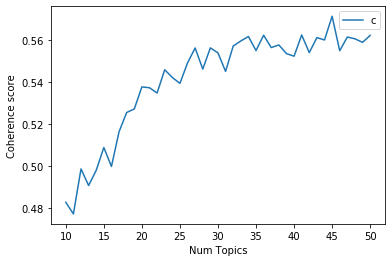

In [55]:
# Show graph
import matplotlib.pyplot as plt
%matplotlib inline
limit=51; start=10; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.savefig('TopicNum_coherence.png')
plt.show()

In [56]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.4828
Num Topics = 11  has Coherence Value of 0.4772
Num Topics = 12  has Coherence Value of 0.4986
Num Topics = 13  has Coherence Value of 0.4908
Num Topics = 14  has Coherence Value of 0.498
Num Topics = 15  has Coherence Value of 0.5088
Num Topics = 16  has Coherence Value of 0.4998
Num Topics = 17  has Coherence Value of 0.5163
Num Topics = 18  has Coherence Value of 0.5255
Num Topics = 19  has Coherence Value of 0.5272
Num Topics = 20  has Coherence Value of 0.5377
Num Topics = 21  has Coherence Value of 0.5373
Num Topics = 22  has Coherence Value of 0.5348
Num Topics = 23  has Coherence Value of 0.5458
Num Topics = 24  has Coherence Value of 0.5421
Num Topics = 25  has Coherence Value of 0.5393
Num Topics = 26  has Coherence Value of 0.5491
Num Topics = 27  has Coherence Value of 0.5562
Num Topics = 28  has Coherence Value of 0.5461
Num Topics = 29  has Coherence Value of 0.5562
Num Topics = 30  has Coherence Value of 0.5538
Num Topics = 3

In [59]:
ldamallet_45 = model_list[35]

pprint(ldamallet_45.print_topics(num_words=10, num_topics= 45))

[(0,
  '0.054*"shit" + 0.053*"fuck" + 0.049*"yall" + 0.038*"im" + 0.023*"ass" + '
  '0.022*"aint" + 0.021*"gonna" + 0.016*"dont" + 0.015*"realli" + '
  '0.015*"damn"'),
 (1,
  '0.045*"paper" + 0.039*"toilet" + 0.038*"store" + 0.027*"buy" + 0.022*"food" '
  '+ 0.022*"groceri" + 0.017*"peopl" + 0.015*"shop" + 0.012*"water" + '
  '0.011*"walmart"'),
 (2,
  '0.041*"peopl" + 0.027*"symptom" + 0.025*"immun" + 0.024*"risk" + '
  '0.017*"system" + 0.016*"infect" + 0.013*"amp" + 0.012*"cold" + '
  '0.012*"cough" + 0.011*"viru"'),
 (3,
  '0.050*"market" + 0.047*"stock" + 0.021*"economi" + 0.016*"point" + '
  '0.014*"fear" + 0.014*"price" + 0.012*"drop" + 0.011*"impact" + '
  '0.011*"global" + 0.010*"dow"'),
 (4,
  '0.086*"china" + 0.035*"wuhan" + 0.033*"viru" + 0.031*"chines" + '
  '0.019*"outbreak" + 0.015*"world" + 0.015*"anim" + 0.014*"human" + '
  '0.014*"start" + 0.012*"spread"'),
 (5,
  '0.105*"trump" + 0.062*"realdonaldtrump" + 0.029*"lie" + 0.027*"presid" + '
  '0.019*"hoax" + 0.018*"amp

In [19]:
ldamallet_45 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=45, id2word=id2word, alpha= 5.0, random_seed = 750)
pprint(ldamallet_45.print_topics(num_words=10, num_topics= 45))

[(0,
  '0.054*"shit" + 0.053*"fuck" + 0.049*"yall" + 0.038*"im" + 0.023*"ass" + '
  '0.022*"aint" + 0.021*"gonna" + 0.016*"dont" + 0.015*"realli" + '
  '0.015*"damn"'),
 (1,
  '0.045*"paper" + 0.039*"toilet" + 0.038*"store" + 0.027*"buy" + 0.022*"food" '
  '+ 0.022*"groceri" + 0.017*"peopl" + 0.015*"shop" + 0.012*"water" + '
  '0.011*"walmart"'),
 (2,
  '0.041*"peopl" + 0.027*"symptom" + 0.025*"immun" + 0.024*"risk" + '
  '0.017*"system" + 0.016*"infect" + 0.013*"amp" + 0.012*"cold" + '
  '0.012*"cough" + 0.011*"viru"'),
 (3,
  '0.050*"market" + 0.047*"stock" + 0.021*"economi" + 0.016*"point" + '
  '0.014*"fear" + 0.014*"price" + 0.012*"drop" + 0.011*"impact" + '
  '0.011*"global" + 0.010*"dow"'),
 (4,
  '0.086*"china" + 0.035*"wuhan" + 0.033*"viru" + 0.031*"chines" + '
  '0.019*"outbreak" + 0.015*"world" + 0.015*"anim" + 0.014*"human" + '
  '0.014*"start" + 0.012*"spread"'),
 (5,
  '0.105*"trump" + 0.062*"realdonaldtrump" + 0.029*"lie" + 0.027*"presid" + '
  '0.019*"hoax" + 0.018*"amp

In [89]:
doc_45 = ldamallet_45.load_document_topics()
doc_45 = list(doc_45)

## Plot Topic Word Cloud

In [37]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

#cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
def plot_word_cloud(N, model):
    cloud = WordCloud(stopwords=STOPWORDS,
                    background_color='white',
                    width=1000,
                    height=750,
                    max_words=10,
                    colormap='tab10',
                    #color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)

    topics = model.show_topics(formatted=False, num_topics=N)

    fig, axes = plt.subplots(9, 5, figsize=(20,40), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        if i > N-1:
            break
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title(topic_names[i], fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

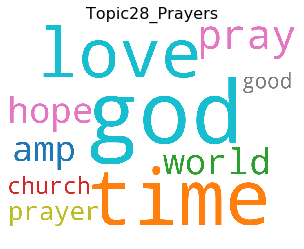

In [38]:
topic_names = ['Topic00_IntenseExpression', 'Topic01_Shopping', 'Topic02_Symptoms', 'Topic03_Stocks', 'Topic04_ChinaOutbreak', 'Topic05_Trump', 'Topic06_NegativeEmotions', 'Topic07_Adaptation', 'Topic08_Prevention', 'Topic09_Closures', 'Topic10_Pandemic', 'Topic11_Vaccine', 'Topic12_FluDeaths', 'Topic13_Dissemination', 'Topic14_News', 'Topic15_InternationalOutbreak', 'Topic16_TaskForceConference', 'Topic17_Masks', 'Topic18_Exercise', 'Topic19_Ethnicity', 'Topic20_Cancellations', 'Topic21_CaresAct', 'Topic22_Home', 'Topic23_Sport', 'Topic24_SocialDistancing', 'Topic25_Education', 'Topic26_Employment', 'Topic27_PublicHealth', 'Topic28_Prayers', 'Topic29_CDC', 'Topic30_OnlineMedia', 'Topic31_Florida', 'Topic32_Travel', 'Topic33_Time', 'Topic34_Passive', 'Topic35_Election', 'Topic36_LocalBusinessSupport', 'Topic37_NewYork', 'Topic38_TestResults', 'Topic39_COVIDNumbers', 'Topic40_Hotspots', 'Topic41_Hashtags', 'Topic42_ConfirmedCases', 'Topic43_PersonalExpression', 'Topic44_Testing']
cloud = WordCloud(stopwords=STOPWORDS,
                    background_color='white',
                    width=1000,
                    height=750,
                    max_words=10,
                    colormap='tab10',
                    #color_func=lambda *args, **kwargs: cols[i],
                    prefer_horizontal=1.0)
i=28
topics = ldamallet_45.show_topics(formatted=False, num_topics=45)
topic_words = dict(topics[i][1])
cloud.generate_from_frequencies(topic_words, max_font_size=300)
plt.gca().imshow(cloud)
plt.gca().set_title(topic_names[i], fontdict=dict(size=16))
plt.gca().axis('off')
plt.show()

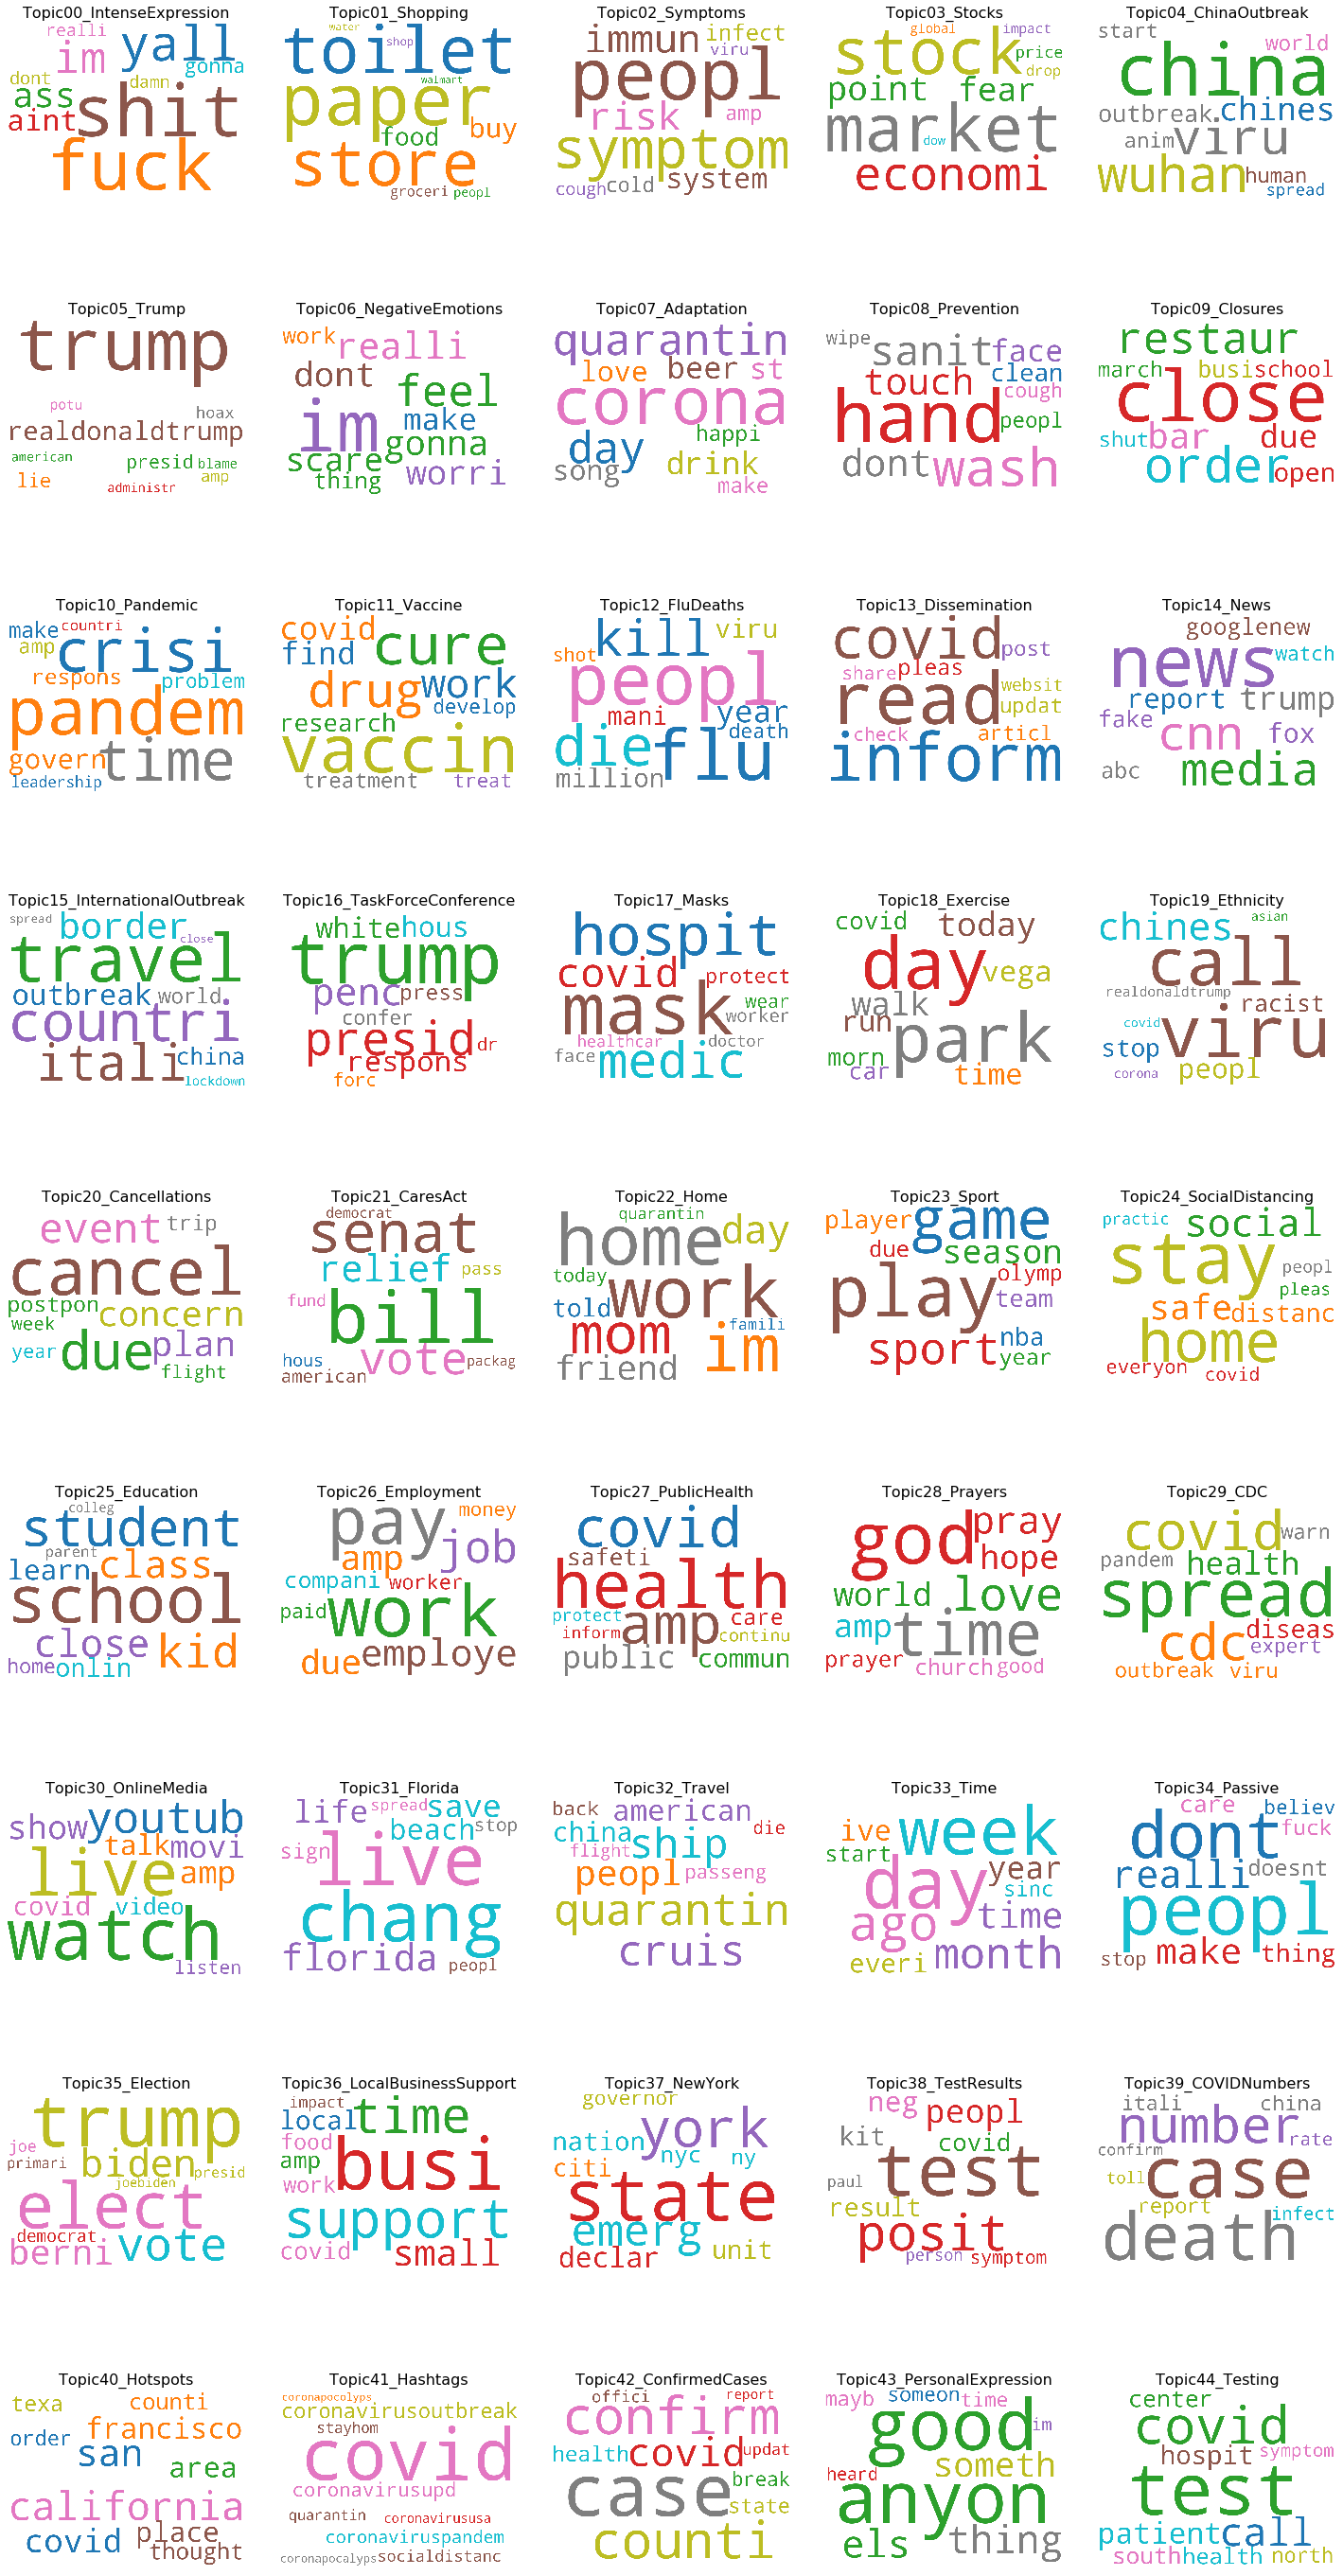

In [39]:
#top_topics = [30,14,34,3,20,15,19,37,7,23,18,25,22,26,40,39,43,38,44,36]
plot_word_cloud(45, ldamallet_45)

## Get Topic Distribution

In [22]:
from datetime import datetime
def topic_distribution(doc):
    print("Start")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    sent_topics_df = pd.DataFrame() 
    top_num = []
    for i in range(len(doc)):
        top_dist = []
        for j, (topic_num, prop_topic) in enumerate(doc[i]):
            top_dist.append(round(prop_topic,4))
            if i ==0:
                top_num.append('Topic '+ str(topic_num))
        sent_topics_df = sent_topics_df.append(pd.Series(top_dist), ignore_index=True)
    sent_topics_df.columns = top_num
    contents = pd.Series(texts)
    new_df= pd.concat([sent_topics_df, contents, covid_clean], axis=1)
    print("End")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    return(new_df)

In [24]:
doc_45 = ldamallet_45.load_document_topics()
doc_45 = list(doc_45)

In [25]:
#df_45 = topic_distribution(doc_45)
#df_45.to_csv ('TopDoc_45.csv', index = False, header=True)

Start
2021-03-18 20:59:34
End
2021-03-18 23:20:44


In [21]:
df_45 = pd.read_csv('TopDocWithNames_45.csv')
df_45

,Unnamed: 0,Topic00_IntenseExpression,Topic01_Shopping,Topic02_Symptoms,Topic03_Stocks,Topic04_ChinaOutbreak,Topic05_Trump,Topic06_NegativeEmotions,Topic07_Adaption,Topic08_Prevention,...,month,date,stemmer,County,State,ADI,Code,IsHotspot,ADI_level,New_ADI_level
0,0,0,0.4701,0.0085,0.0085,0.0085,0.0085,0.0085,0.0855,0.0085,...,January,23.0,"['lysol', 'da', 'fuck', 'outta', 'everyth', 'b...",Tarrant County,Texas,55.0,48439,False,mid,mid
1,1,1,0.0159,0.0159,0.0159,0.0159,0.0159,0.0159,0.0159,0.0159,...,January,23.0,"['coronaviru', 'confirm', 'washington']",Allegan County,Michigan,55.0,26005,False,mid,mid
2,2,2,0.0159,0.0159,0.0159,0.0159,0.0159,0.0159,0.0159,0.0159,...,January,23.0,"['hmmmmm', 'could', 'coronaviru', 'soon', 'new...",Leon County,Florida,56.5,12073,False,mid,mid
3,3,3,0.0093,0.0093,0.0093,0.0093,0.0093,0.0093,0.0093,0.0093,...,January,23.0,"['million', 'peopl', 'wuhan', 'larger', 'new',...",Maricopa County,Arizona,48.0,4013,True,mid,mid
4,4,4,0.0101,0.0101,0.0101,0.1010,0.0101,0.0101,0.0101,0.0101,...,January,23.0,"['wuhan', 'cut', 'inflow', 'outflow', 'transpo...",Washington,District of Columbia,13.0,11001,False,low,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269551,269551,269551,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.1242,...,March,14.0,"['joke', 'show', 'wed', 'candysbbr', 'kid', 'f...",San Diego County,California,17.0,6073,False,mid,low
269552,269552,269552,0.0051,0.0051,0.0051,0.0960,0.0051,0.0051,0.0051,0.0051,...,March,14.0,"['instead', 'yell', 'trump', 'need', 'ask', 's...",Escambia County,Florida,64.0,12033,False,high,mid
269553,269553,269553,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,0.0065,...,March,14.0,"['congrat', 'jack', 'foundationma', 'teach', '...",King County,Washington,16.0,53033,True,low,low
269554,269554,269554,0.1389,0.0139,0.0139,0.0139,0.0139,0.0139,0.0139,0.0139,...,March,14.0,"['dam', 'good', 'idea']",Los Angeles County,California,19.0,6037,False,mid,low


## Get Dominant Topic

In [26]:
def dominant_topic(N,prev_df):
    df = prev_df[:]
    df['Topic'] = 'None'
    num_list = [x for x in range(N)]
    for i in range(len(df)):
        for j in range(0,N):
            if df.iloc[i, j] == max(df.iloc[i, num_list]):
                df['Topic'][i] = df.columns[j]
                break
    return df

In [27]:
df_45_with_Top = dominant_topic(45,df_45)
df_45_with_Top.to_csv('Final_DominantTopicWithNames_45.csv', index = False, header=True)

In [28]:
covid_county = covid_clean.drop_duplicates('County')
covid_county['ADI'].quantile([.2, .8])

0.2    43
0.8    77
Name: ADI, dtype: object

## Define ADIs and Hotspots

In [31]:
#covid['SDI_level'] = covid.apply(lambda x: 'low' if x <=50 ('high' if x>50 else x) for x in covid['SDI'])
df_45['New_ADI_level'] = pd.Series([])
#covid['SDI_level_extreme'] = pd.Series([])
for i in range(len(df_45)):
    if df_45['ADI'][i] <=43:
        df_45['New_ADI_level'][i] ='low'
    elif df_45['ADI'][i] > 43 and df_45['ADI'][i] <= 77:
        df_45['New_ADI_level'][i] = 'mid'
    elif df_45['ADI'][i] > 77:
        df_45['New_ADI_level'][i] = 'high'

In [32]:
df_45['New_ADI_level'].value_counts()

low     134956
mid     123047
high     11553
Name: New_ADI_level, dtype: int64

In [33]:
len(df_45)

269556

In [44]:
df_45.columns = topic_names +[ 0,         'index',       'user_id',
           'status_id',    'created_at',         'month',          'date',
             'stemmer',        'County',         'State',           'ADI',
                'Code',     'IsHotspot', 'New_ADI_level']

In [47]:
df_45['Topic'] = df_45_with_Top['Topic']

In [173]:
covid_hs = pd.read_pickle(r'FinalProcessed_withTopics.pkl')
df_45['IsHotspot'] = covid_hs['IsHotspot']

In [99]:
df_45.to_csv ('TopDocComplete_45.csv', index = False, header=True)

In [6]:
df_45 = pd.read_csv('TopDocComplete_45.csv')

## Get Representative Tweet

In [13]:
def representative_tweet(df):
    # Group top 5 sentences under each topic
    sent_topics_sorteddf_mallet = pd.DataFrame()

    sent_topics_outdf_grpd = df.groupby('Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                                grp.sort_values([str(i)], ascending=[0]).head(1)], 
                                                axis=0)

    # Reset Index    
    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # Format
    #sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

    # Show
    #sent_topics_sorteddf_mallet.head()
    return sent_topics_sorteddf_mallet

In [14]:
df_45_Representative_Tweet =  representative_tweet(df_45_with_Top)
df_45_Representative_Tweet.to_csv('RepresentativeTweets_45.csv', index = False, header=True)
#df_45_Representative_Tweet

In [18]:
df_45_Representative_Tweet['Top_Dist'] = pd.Series([])
for i in range(45):
    df_45_Representative_Tweet['Top_Dist'][i] = df_45_Representative_Tweet[topic_names[i]][i]

df_45_Representative_Tweet = df_45_Representative_Tweet.drop(topic_names, axis =1)
df_45_Representative_Tweet[['Topic', 'status_id', 'stemmer', 'text','Top_Dist']].to_csv('RepresentativeTweets_45.csv', index = False, header=True)

## Prepare Data for Visualization

In [19]:
def cnt_matrix_month(N, df):
    tm = pd.DataFrame(0, index = ['January', 'February', 'March'], columns=topic_names)
    n = 0
    for i in range(len(df)):
        try:
            tm[df['Topic'][i]][df['month'][i]] +=1
        except:
            n+=1
    return tm

def odd_matrix_month(N, df):
    ts = pd.DataFrame(0.0, index = ['January', 'February', 'March'], columns=topic_names)
    for i in range(0,len(df)):
        for j in range(N):
            ts.iloc[i][j] = df.iloc[i][j]/sum(df.iloc[i])
    return ts

def cnt_matrix_ADI(N, df, extreme = False, new = False):
    if extreme == True:
        ts = pd.DataFrame(0, index = ['high', 'low'], columns=df.columns[:N])
    else:
        ts = pd.DataFrame(0, index = ['high', 'mid', 'low'], columns=topic_names)
    n = 0
    if new == True:
        t = 'New_ADI_level'
    else:
        t = 'ADI_level'
    for i in df.index.tolist():
        try:
            ts[df['Topic'][i]][df[t][i]] +=1
        except:
            n+=1
    return ts

def odd_matrix_ADI(N, df, extreme = False):
    if extreme == True:
        ts = pd.DataFrame(0.0, index = ['high', 'low'], columns=df.columns[:N])
    else:
        ts = pd.DataFrame(0.0, index = ['high', 'mid','low'], columns=topic_names)
    for i in range(0,len(df)):
        for j in range(N):
            ts.iloc[i][j] = df.iloc[i][j]/sum(df.iloc[i])
    return ts

In [85]:
df_45_with_Top['Topic'] = df_45_with_Top['Topic'].str[6:].astype(int)
df_45_with_Top['Topic'] = [topic_names[i] for i in df_45_with_Top['Topic'].tolist()]

In [20]:
def plot_log_odds_ADI(N, df, extreme = False):
    plot_df = df.T
    plot_df['OR'] = [math.log(x) for x in (plot_df['high'] / plot_df['low']).tolist()]
    plot_df = plot_df.reset_index()
    plot_df['colors'] = ['red' if x < 0 else 'green' for x in plot_df['OR']]
    plot_df.sort_values('OR', inplace=True)
    plot_df.reset_index(inplace = True)

    # Draw plot
    plt.figure(figsize=(14,8), dpi= 80)
    plt.hlines(y=plot_df.index, xmin=0, xmax=plot_df.OR, color=plot_df.colors, alpha=0.4, linewidth=15)

    if extreme == True:
        t = 'ADI_Extreme'
    else:
        t = 'ADI'

    # Decorations
    plt.gca().set(ylabel='$Topics$', xlabel='$Log Odds Ratio$')
    plt.yticks(plot_df.index, plot_df['index'], fontsize=14)
    plt.title('Log Odds Ratio for High and Low ' + t, fontdict={'size':20})
    plt.grid(linestyle='--', alpha=0.5)
    
    custom_lines = [Line2D([0], [0], color='lightcoral', lw=4),
                    Line2D([0], [0], color='darkseagreen', lw=4)]
    plt.legend(custom_lines, ['Low', 'High'], loc = 'lower right',fontsize=14)
    plt.savefig('LogOdds_'+ t +'_' + str(N)+'.png')
    plt.show()

In [111]:
len(covid_clean)

269556

In [25]:
df_45_with_Top = df_45[:]

In [167]:
df_hotspot = df_45_with_Top.drop(df_45_with_Top.columns[[30,8,35,28,22,5,34,2,31,19,43,21]], axis = 1)
df_ADI = df_45_with_Top.drop(df_45_with_Top.columns[[33,19,39,25,8,9,20,38,26,30,35,2,7,1,29,5,15,22,44,32,17]], axis = 1)
df_hotspotADI = df_45_with_Top.drop(df_45_with_Top.columns[[6,35,20,30,10,12,27,44,4,8,43,25,19,2,22,33,29,14,16,23,1,5,39,17,7,31,28,36,34,21,32,15]], axis = 1)

## Visualization - Log Odds Ratio

In [36]:
from matplotlib.lines import Line2D

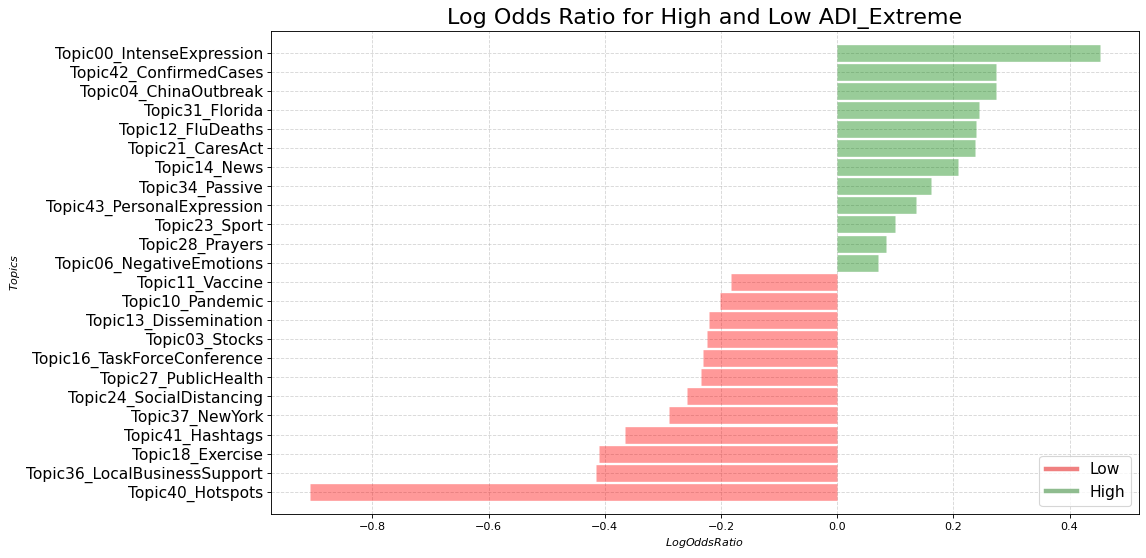

In [87]:
cntNewADI_Extreme_45 = cnt_matrix_ADI(24, df_ADI, extreme= True, new = True)
oddNewADI_Extreme_45 = odd_matrix_ADI(24, cntNewADI_Extreme_45, extreme= True)
#oddADI_Extreme_45.columns = topic_names
plot_log_odds_ADI(24, oddNewADI_Extreme_45, extreme= True)

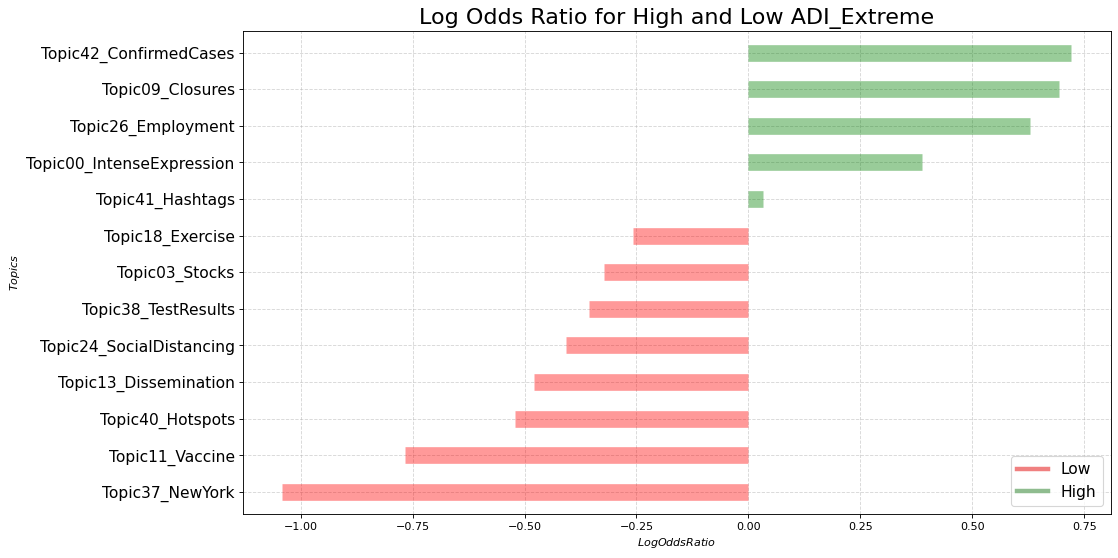

In [164]:
df_hotspotADI =df_hotspotADI[df_hotspotADI['IsHotspot'] == True]
cntNewADI_hp_Extreme_45 = cnt_matrix_ADI(13, df_hotspotADI, extreme= True, new = True)
oddNewADI_hp_Extreme_45 = odd_matrix_ADI(13, cntNewADI_hp_Extreme_45, extreme= True)
#oddADI_Extreme_45.columns = topic_names
plot_log_odds_ADI(13, oddNewADI_hp_Extreme_45, extreme= True)

In [89]:
def cnt_matrix_hotspot(N, df):
    ts = pd.DataFrame(0, index = ['True', 'False'], columns=df.columns[:N])
    n = 0
    for i in range(len(df)):
        try:
            ts[df['Topic'][i]][str(df['IsHotspot'][i])] +=1
        except:
            n+=1
    return ts
def odd_matrix_hotspot(N, df):
    ts = pd.DataFrame(0.0, index = ['True', 'False'], columns=df.columns[:N])
    for i in range(0,len(df)):
        for j in range(N):
            ts.iloc[i][j] = df.iloc[i][j]/sum(df.iloc[i])
    return ts

In [90]:
def plot_log_odds_hotspot(N, df):
    plot_df = df.T
    plot_df['OR'] = [math.log(x) for x in (plot_df['True'] / plot_df['False']).tolist()]
    plot_df = plot_df.reset_index()
    plot_df['colors'] = ['red' if x < 0 else 'green' for x in plot_df['OR']]
    plot_df.sort_values('OR', inplace=True)
    plot_df.reset_index(inplace = True)

    # Draw plot
    plt.figure(figsize=(14,11), dpi= 80)
    plt.hlines(y=plot_df.index, xmin=0, xmax=plot_df.OR, color=plot_df.colors, alpha=0.4, linewidth=12)

    # Decorations
    plt.gca().set(ylabel='$Topics$', xlabel='$Log Odds Ratio$')
    plt.yticks(plot_df.index, plot_df['index'], fontsize=14)
    plt.title('Log Odds Ratio for Hotspots and Non-hotspots', fontdict={'size':20})
    plt.grid(linestyle='--', alpha=0.5)
    
    custom_lines = [Line2D([0], [0], color='lightcoral', lw=4),
                    Line2D([0], [0], color='darkseagreen', lw=4)]
    plt.legend(custom_lines, ['non-hotspot', 'hotspot'], loc = 'lower right',fontsize = 14)
    plt.savefig('LogOdds_hotspot_'+str(N)+'.png')
    plt.show()

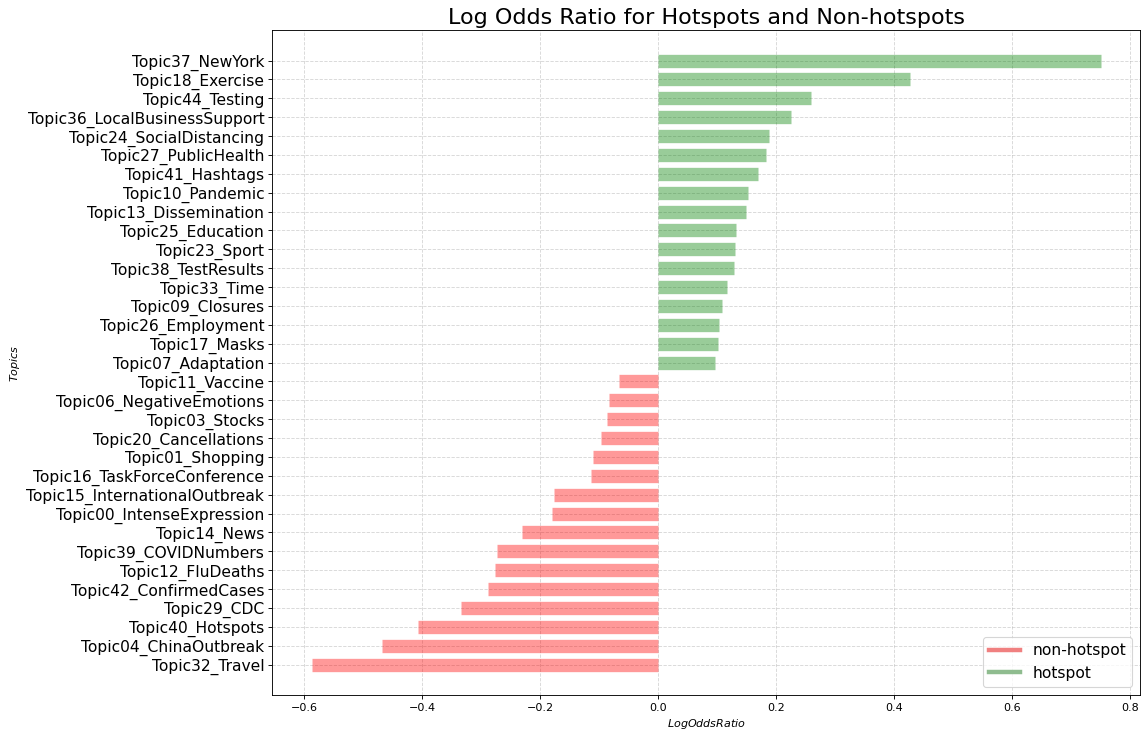

In [165]:
cntHS_45 = cnt_matrix_hotspot(33, df_hotspot)
oddHS_45 = odd_matrix_hotspot(33, cntHS_45)
#oddHS_45.columns = topic_names
plot_log_odds_hotspot(33, oddHS_45)

## Visualization - Topic Dynamic

In [110]:
def plot_topic_dynamic( df,topic, group = None, ax_out = None, cross = False):
    temp = df[:]
    
    if group == None:
        temp = temp.iloc[:,[topic,-12,-11]].groupby(['month','date']).mean().reindex(['January', 'February','March'],level =0).reset_index()
        temp ['date'] = temp['month'] + ' ' +temp['date'].astype(int).astype(str)
        temp =temp.drop(['month'], axis =1)
        temp.plot(x='date',rot =45, title = topic_names[topic])

    elif group == 'ADI_level':
        temp = temp.iloc[:,[topic,-12,-11,-4]].groupby(['month','date', group]).mean().reindex(['January', 'February','March'],level =0).reset_index()
        temp ['date'] = temp['month'] + ' ' +temp['date'].astype(int).astype(str)
        temp =temp.drop(['month'], axis =1)
        if ax_out != None:
            #fig_out.add_subplot(ax_out)
            ax =ax_out
        else:
            fig, ax = plt.subplots()
        for label, grp in temp.groupby(group):
            grp.plot(x = 'date', y = topic_names[topic], ax= ax, label = label, rot =45, title = topic_names[topic] + ', ADI Level')

    elif group == 'New_ADI_level':
        temp = temp.iloc[:,[topic, -10,-9,-2]].groupby(['month','date', group]).mean().reindex(['January', 'February','March'],level =0).reset_index()
        temp ['date'] = temp['month'] + ' ' +temp['date'].astype(int).astype(str)
        temp =temp.drop(['month'], axis =1)
       
        i =0 
        for label, grp in temp.groupby(group):
            if i == 0:
                grp1 = grp
                label1 = label
                i+=1
            grp2 = grp
            label2 = label
        if cross == False:
            temp1 = pd.DataFrame(index = date, columns = [group, topic_names[topic]])
            temp1.index = temp1.index.set_names(['date'])
            grp1 = grp1.set_index('date')
            grp2 = grp2.set_index('date')

            for i in temp1.index.tolist():
                if i in grp1.index.tolist():
                    temp1[group][i] = grp1[group][i]
                    temp1[topic_names[topic]][i] = grp1[topic_names[topic]][i]
                else:
                    temp1[group][i] = grp1[group].unique()[0]
                    temp1[topic_names[topic]][i] = 0
            temp1 = temp1.reset_index()

            temp2 = pd.DataFrame(index = date, columns = [group, topic_names[topic]])
            temp2.index = temp2.index.set_names(['date'])
            for i in temp2.index.tolist():
                if i in grp2.index.tolist():
                    temp2[group][i] = grp2[group][i]
                    temp2[topic_names[topic]][i] = grp2[topic_names[topic]][i]
                else:
                    temp2[group][i] = grp2[group].unique()[0]
                    temp2[topic_names[topic]][i] = 0
            temp2 = temp2.reset_index()
        else:
            temp1 = pd.DataFrame(index = date2, columns = [group, topic_names[topic]])
            temp1.index = temp1.index.set_names(['date'])
            grp1 = grp1.set_index('date')
            grp2 = grp2.set_index('date')

            for i in temp1.index.tolist():
                try:
                    if i in grp1.index.tolist():
                        temp1[group][i] = grp1[group][i]
                        temp1[topic_names[topic]][i] = grp1[topic_names[topic]][i]
                    else:
                        temp1[group][i] = grp1[group].unique()[0]
                        temp1[topic_names[topic]][i] = 0
                except:
                    continue
            temp1 = temp1.reset_index()

            temp2 = pd.DataFrame(index = date2, columns = [group, topic_names[topic]])
            temp2.index = temp2.index.set_names(['date'])
            for i in temp2.index.tolist():
                try:
                    if i in grp2.index.tolist():
                        temp2[group][i] = grp2[group][i]
                        temp2[topic_names[topic]][i] = grp2[topic_names[topic]][i]
                    else:
                        temp2[group][i] = grp2[group].unique()[0]
                        temp2[topic_names[topic]][i] = 0
                except:
                    continue
            temp2 = temp2.reset_index()


        fig, ax = plt.subplots()
        temp1.plot(x = 'date', y = topic_names[topic], ax= ax, label = label1, rot =45, title = topic_names[topic] + ', ADI Level')
        temp2.plot(x = 'date', y = topic_names[topic], ax= ax, label = label2, rot =45, title = topic_names[topic] + ', ADI Level')
        ax.set_ylabel('Topic Probability')

    elif group == 'IsHotspot':
        temp = temp.iloc[:,[topic,-10,-9, -3]].groupby(['month','date', group]).mean().reindex(['January', 'February','March'],level =0).reset_index()
        temp ['date'] = temp['month'] + ' ' +temp['date'].astype(int).astype(str)
        temp =temp.drop(['month'], axis =1)
        if ax_out != None:
            #fig_out.add_subplot(ax_out)
            ax =ax_out
        else:
            fig, ax = plt.subplots()
        i =0 
        for label, grp in temp.groupby(group):
            if i == 0:
                grp1 = grp
                label1 = label
                i+=1
            grp2 = grp
            label2 = label

        temp1 = pd.DataFrame(index = date, columns = [group, topic_names[topic]])
        temp1.index = temp1.index.set_names(['date'])
        grp1 = grp1.set_index('date')
        grp2 = grp2.set_index('date')

        for i in temp1.index.tolist():
            if i in grp1.index.tolist():
                temp1[group][i] = grp1[group][i]
                temp1[topic_names[topic]][i] = grp1[topic_names[topic]][i]
            else:
                temp1[group][i] = grp1[group].unique()[0]
                temp1[topic_names[topic]][i] = 0
        temp1 = temp1.reset_index()

        temp2 = pd.DataFrame(index = date, columns = [group, topic_names[topic]])
        temp2.index = temp2.index.set_names(['date'])
        for i in temp2.index.tolist():
            if i in grp2.index.tolist():
                temp2[group][i] = grp2[group][i]
                temp2[topic_names[topic]][i] = grp2[topic_names[topic]][i]
            else:
                temp2[group][i] = grp2[group].unique()[0]
                temp2[topic_names[topic]][i] = 0
        temp2 = temp2.reset_index()
        

        temp1.plot(x = 'date', y = topic_names[topic], ax= ax, label = label1, rot =45, title = topic_names[topic] + ', Hotspots')
        temp2.plot(x = 'date', y = topic_names[topic], ax= ax, label = label2, rot =45, title = topic_names[topic] + ', Hotspots')
        ax.set_ylabel('Topic Probability')


In [111]:
date = []
jan_date = ['January ' + str(i) for i in range(23,32) ]
feb_date = ['February '+ str(i) for i in range(1, 30)]
mar_date = ['March ' + str(i) for i in range(1, 26)]
date.extend(jan_date)
date.extend(feb_date)
date.extend(mar_date)

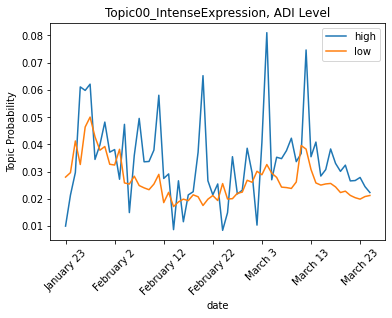

In [170]:
plot_topic_dynamic(df_45_with_Top[df_45_with_Top['New_ADI_level'] != 'mid'], topic = 0, group = 'New_ADI_level')

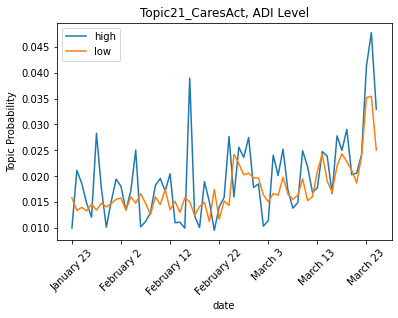

In [171]:
plot_topic_dynamic(df_45_with_Top[df_45_with_Top['New_ADI_level'] != 'mid'], topic = 21, group = 'New_ADI_level')

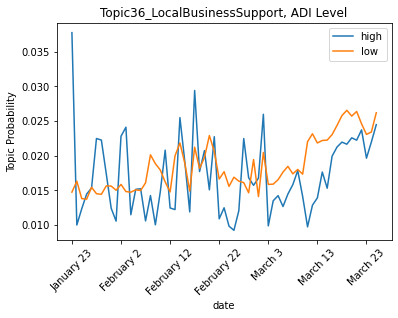

In [168]:
plot_topic_dynamic(df_45_with_Top[df_45_with_Top['New_ADI_level'] != 'mid'], topic = 36, group = 'New_ADI_level')

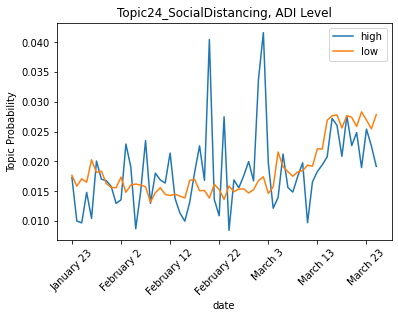

In [172]:
plot_topic_dynamic(df_45_with_Top[df_45_with_Top['New_ADI_level'] != 'mid'], topic = 24, group = 'New_ADI_level')